In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_dir = "data"

def filename(what: str) -> str:
    return os.path.join(base_dir, f"{what}.csv")

In [3]:
df_boxes = pd.read_csv(filename("boxes"))
df_answers = pd.read_csv(filename("answers"))

In [4]:
len(df_boxes), len(df_answers)

(32711, 1035840)

In [5]:
# Since all tasks are binary, we can use one pivot table for all
# question simultaenously

categories = ["no", "yes", "cant_solve"]

df_reduced = (
    df_answers.assign(
        answer = lambda df: df.answer.where(~df.cant_solve, "cant_solve")
    ).pipe(
        lambda df: pd.pivot_table(
            df,
            index=["crop_id", "question"],
            columns="answer",
            values="user_id", 
            aggfunc="count",
            fill_value=0
        )
    ).reset_index()
    .assign(
        mv = lambda df: np.array(categories)[df[categories].to_numpy().argmax(axis=-1)]
    )
)

In [6]:
df_reduced

answer,crop_id,question,cant_solve,no,yes,mv
0,00085331-d312-4465-bf58-8f42790157c5_cropped_0...,human being,0,0,5,yes
1,00085331-d312-4465-bf58-8f42790157c5_cropped_0...,on a bike,0,5,0,no
2,00085331-d312-4465-bf58-8f42790157c5_cropped_0...,on poster/picture/billboard,0,5,0,no
3,00085331-d312-4465-bf58-8f42790157c5_cropped_0...,on wheels,0,5,0,no
4,00085331-d312-4465-bf58-8f42790157c5_cropped_0...,reflection of a person,0,5,0,no
...,...,...,...,...,...,...
196261,ffff35df-9d16-4d92-a44d-5904a3983aa2_cropped_f...,on a bike,1,5,0,no
196262,ffff35df-9d16-4d92-a44d-5904a3983aa2_cropped_f...,on poster/picture/billboard,0,5,0,no
196263,ffff35df-9d16-4d92-a44d-5904a3983aa2_cropped_f...,on wheels,0,6,4,no
196264,ffff35df-9d16-4d92-a44d-5904a3983aa2_cropped_f...,reflection of a person,0,5,0,no


Alternatively, we can also save the data in a format where the total majority vote for each attribute is listed for each object.

In [7]:
df_mv_attributes = df_reduced.pipe(
    lambda df: pd.pivot(
        df,
        index="crop_id",
        columns="question",
        values="mv"
    )
)

df_mv_attributes.head(3)

question,human being,on a bike,on poster/picture/billboard,on wheels,reflection of a person,statue/ mannequin
crop_id,,,,,,
00085331-d312-4465-bf58-8f42790157c5_cropped_04275bfb-359c-4c9a-8a3b-80c1d1e461af,yes,no,no,no,no,no
00085331-d312-4465-bf58-8f42790157c5_cropped_1ba540b0-018c-4921-8af9-1de19e84bb79,yes,no,no,no,no,no
00085331-d312-4465-bf58-8f42790157c5_cropped_1e28bedc-e12e-4e52-bf3e-469d0862525a,yes,no,no,no,no,no


### Which combinations of (majority) attributes do occur?

In [8]:
mv_attribute = df_mv_attributes.to_numpy()

mv_attribute = np.where(
    mv_attribute == "no",
    0,
    np.where(
        mv_attribute == "yes",
        1, 2
    )
)

mv_identities = np.array(["".join(row) for row in mv_attribute.astype(str)])
unique_mv_identities = np.unique(mv_identities)

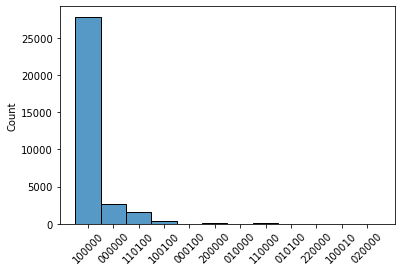

In [9]:
sns.histplot(mv_identities)
plt.xticks(rotation=45)
plt.show()

In [10]:
counts = (
    unique_mv_identities.reshape(-1, 1)
    == mv_identities.reshape(1, -1)
).sum(axis=-1)

cols = zip(*[
    list(map(lambda c: categories[int(c)], val))
    for val in unique_mv_identities
])

df_unique = pd.DataFrame({
    k: v
    for k, v in zip(
        df_mv_attributes.columns,
        cols
    )
}).assign(
    frequency = lambda _: counts,
    code = lambda _: unique_mv_identities
).pipe(
    lambda df: df.sort_values(
        by="frequency",
        ascending=False
    ).reset_index(drop=True)
)

df_unique

,human being,on a bike,on poster/picture/billboard,on wheels,reflection of a person,statue/ mannequin,frequency,code
0,yes,no,no,no,no,no,27873,100000
1,no,no,no,no,no,no,2702,000000
2,yes,yes,no,yes,no,no,1591,110100
3,yes,no,no,yes,no,no,420,100100
4,cant_solve,no,no,no,no,no,55,200000
5,yes,yes,no,no,no,no,36,110000
6,no,yes,no,no,no,no,15,010000
7,no,no,no,yes,no,no,10,000100
8,no,yes,no,yes,no,no,6,010100
9,no,cant_solve,no,no,no,no,1,020000
